# Restaurants/Food Facilities Inspections by Neighborhood
### by Isaiah Henck

Datasets:<br>
[Food Facility/Restaurant Inspection Violations](https://data.wprdc.org/dataset/allegheny-county-restaurant-food-facility-inspection-violations/resource/1a1329e2-418c-4bd3-af2c-cc334e7559af)<br>
[Neighborhoods](https://data.wprdc.org/dataset/neighborhoods2)

I'll start by loading in the neighboorhood shapefile data&ndash;not entirely sure how much I'll even incorporate it, but it's good to have:

In [3]:
import geopandas as geop
import pandas as pd
pgh_hood_map = geop.read_file('neighborhoods/Neighborhoods_.shp')
pgh_hood_map.sample(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
65,66,61,42,003,240600,2,420032406002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,10717292.0,cef157ae-8465-4d17-a92d-6b967104215d,1.284959e+07,29487.680146,"MULTIPOLYGON (((-79.97744 40.47098, -79.97741 ..."
9,10,77,42,003,191100,2,420031911002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,17364276.0,0edad5c4-6965-4f7d-9055-a976593c7c25,1.727222e+07,18827.632117,"POLYGON ((-80.02479 40.44243, -80.02123 40.441..."
20,21,114,42,003,120400,1,420031204001,Block Group 1,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12407882.0,6d679b4d-248d-4c31-b0db-7bc6178a2902,1.241102e+07,15722.291521,"POLYGON ((-79.90562 40.46260, -79.90561 40.462..."


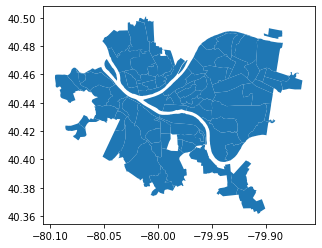

In [87]:
pgh_hood_map.plot()

Next, load the Inspections Violations data, which is in CSV format:

In [4]:
pgh_violations = pd.read_csv('ac_food_inspections_violations.csv')
pgh_violations.sample(5)

,_id,encounter,id,placard_st,facility_name,bus_st_date,description,description_new,num,street,...,zip,inspect_dt,start_time,end_time,municipal,rating,low,medium,high,url
195875,104561389,202306280017,201105090004,1,Mercurio's Gelato & Pizza,2011-04-29,Chain Restaurant with Liquor,Handwashing Facilities,5523,Walnut Street,...,15232.0,2023-06-28,12:30:00,15:15:00,Pittsburgh-107,V,T,F,F,http://appsrv.alleghenycounty.us/reports/rwser...
203590,104569104,201809100006,201405010001,1,Mac & Gold Truck (ZDW-5497) MFF4,2014-04-25,Mobile - Tier II ( Prepared Foods),Hot Holding Temperatures,1707,Babcock Boulevard,...,15209.0,2018-09-07,15:00:00,15:30:00,Shaler,V,F,F,T,http://appsrv.alleghenycounty.us/reports/rwser...
32564,104398078,201510200050,32580,1,Janoski's Farm Market,1984-06-17,Supermarket,Toilet Room,1714,U.S. Route 30,...,15026.0,2015-10-20,15:05:00,16:05:00,Findlay,V,T,F,F,http://appsrv.alleghenycounty.us/reports/rwser...
232759,104598273,201605160061,201605050002,1,Steel City Meats Inc,2016-02-01,Refrigerated Warehouse,Garbage and Refuse,211,Loews Drive,...,15137.0,2016-04-29,12:25:00,13:20:00,North Versailles,V,T,NaN,NaN,http://appsrv.alleghenycounty.us/reports/rwser...
338848,104704362,202103310011,202103310001,1,Pittsburgh Botanic Garden / Welcome Center Can...,2021-04-06,Restaurant without Liquor,"Fabrication, Design, Installation and Maintenance",800,Pinkerton Run Road,...,15071.0,2021-03-31,10:40:00,12:20:00,North Fayette,V,T,F,F,http://appsrv.alleghenycounty.us/reports/rwser...


It's worth noting that this dataset consists of inspections that discovered at least one or more violations. What's most important here to us is the ZIP codes ('zip'), as well as the low-medium-high urgency rating that they implement ('low', 'medium', 'high')<br>
&ndash;If you're like me any, you might take a gander down 'facility_name' to look for some of those restaurants you've always been suspicious of...

Since we only care about a few attributes of the many here, let's filter down the datasheet to get only what we really need:

In [5]:
pgh_violations = pd.read_csv('ac_food_inspections_violations.csv', usecols=['zip','low','medium','high'])
pgh_violations.sample(5)

,zip,low,medium,high
226463,15208.0,T,F,F
44239,15213.0,T,F,F
290028,15237.0,T,NaN,NaN
307625,15222.0,NaN,NaN,NaN
144052,15202.0,F,T,F


Next, we'll initialize our primary dataset that we'll be working with:

In [6]:
neighborhoods = pd.DataFrame(columns = ["Neighborhood", "lo_risk", "me_risk", "hi_risk", "total"])
neighborhoods["Neighborhood"] = pgh_hood_map["hood"]
neighborhoods["lo_risk"] = 0
neighborhoods["me_risk"] = 0
neighborhoods["hi_risk"] = 0
neighborhoods["total"] = 0
neighborhoods.sample(3)

,Neighborhood,lo_risk,me_risk,hi_risk,total
39,Polish Hill,0,0,0,0
67,Mt. Oliver,0,0,0,0
69,Spring Hill-City View,0,0,0,0


Since we are taking the instances of violations and attributing them to neighborhoods according to ZIP codes, we could definitely process them directly into the dataFrame. However, since the dataset consists of a little less than 350,000 data points&ndash;and this is Python runtime&ndash;we need an approach that's not as process-heavy.

In [7]:
dict = {}

for i, inspec in pgh_violations.iterrows():
    try:
        key = int(inspec["zip"])
    except ValueError:
        continue
    if (dict.get(key) == None):
        dict[key] = [0,0,0]
    if (isinstance(inspec["low"], str) and ((inspec["low"]) == "T")):
        dict[key][0]+=1
    elif (isinstance(inspec["medium"], str) and ((inspec["medium"]) == "T")):
        dict[key][1]+=1
    else:
        dict[key][2]+=1
for key in dict:
    if (key == 15208):
        break
    print(key,":", dict.get(key),"\n")

15212 : [6707, 1677, 1598] 

15232 : [2591, 695, 518] 

15136 : [4060, 993, 731] 

15222 : [13291, 3179, 3197] 

15045 : [764, 186, 127] 



Now we can use certain code snippets handed to me personally by the greek gods that'll help me allocate the violations to their respective neighborhoods using their ZIP:

In [9]:
import fpsnippets as snip

for key in dict:
    ziplist = snip.zip_to_neighborhoods(key)
    if ziplist == None:
        continue
    for nbhd in ziplist:
        for i, match in neighborhoods.iterrows():
            if nbhd == match["Neighborhood"]:
                neighborhoods.at[i, "lo_risk"]+=(dict[key][0])
                neighborhoods.at[i, "me_risk"]+=(dict[key][1])
                neighborhoods.at[i, "hi_risk"]+=(dict[key][2])
                
for j, n_tot_calc in neighborhoods.iterrows():
    neighborhoods.at[j, "total"] = neighborhoods.at[j,"lo_risk"]+(neighborhoods.at[j,"me_risk"]*2)+(neighborhoods.at[j,"hi_risk"]*3)
neighborhoods.head(3)

,Neighborhood,lo_risk,me_risk,hi_risk,total
0,Point Breeze North,11107,2683,2286,23331
1,Squirrel Hill North,28342,6797,5778,59270
2,Garfield,12965,3077,2775,27444


Now, we finally have simplified data.

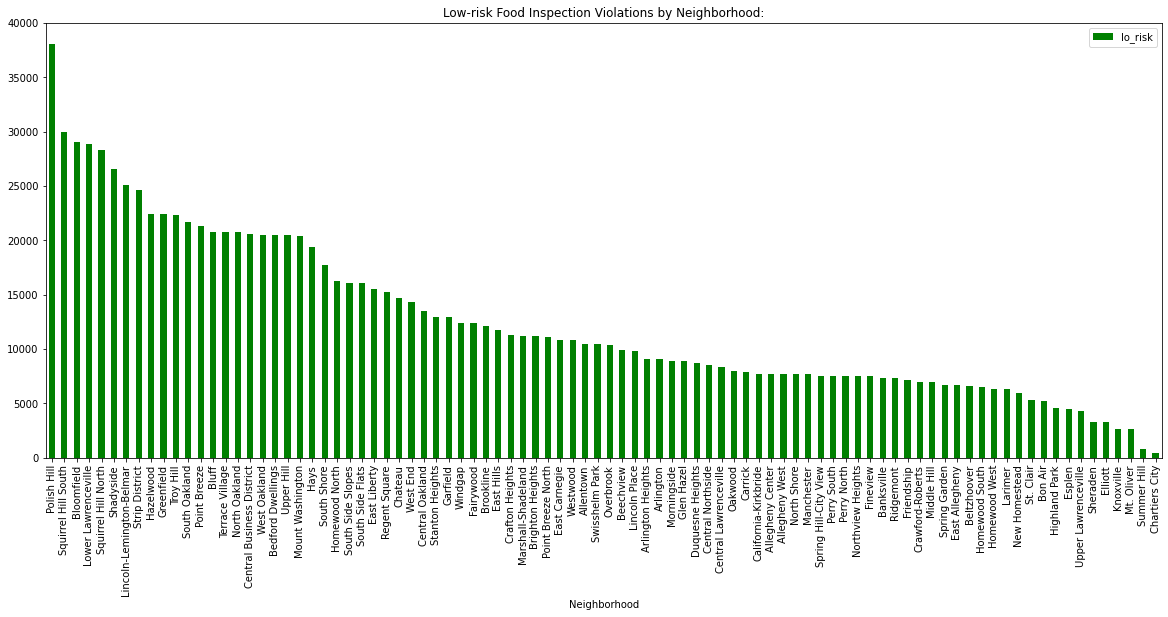

In [10]:
sort_lo = neighborhoods.sort_values("lo_risk", ascending = False)
graph_lo = sort_lo.plot(kind = "bar", x = "Neighborhood", y = "lo_risk", title = "Low-risk Food Inspection Violations by Neighborhood:", figsize= (20,8), color = "green")

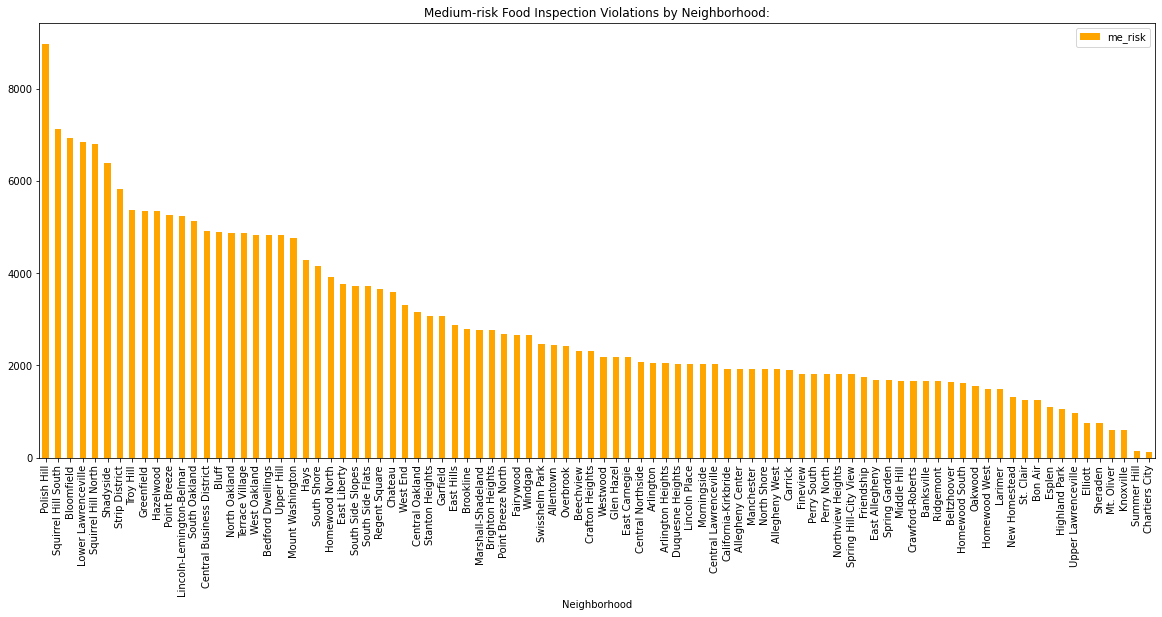

In [11]:
sort_med = neighborhoods.sort_values("me_risk", ascending = False)
graph_med = sort_med.plot(kind = "bar", x = "Neighborhood", y = "me_risk", title = "Medium-risk Food Inspection Violations by Neighborhood:", figsize= (20,8), color = "orange")

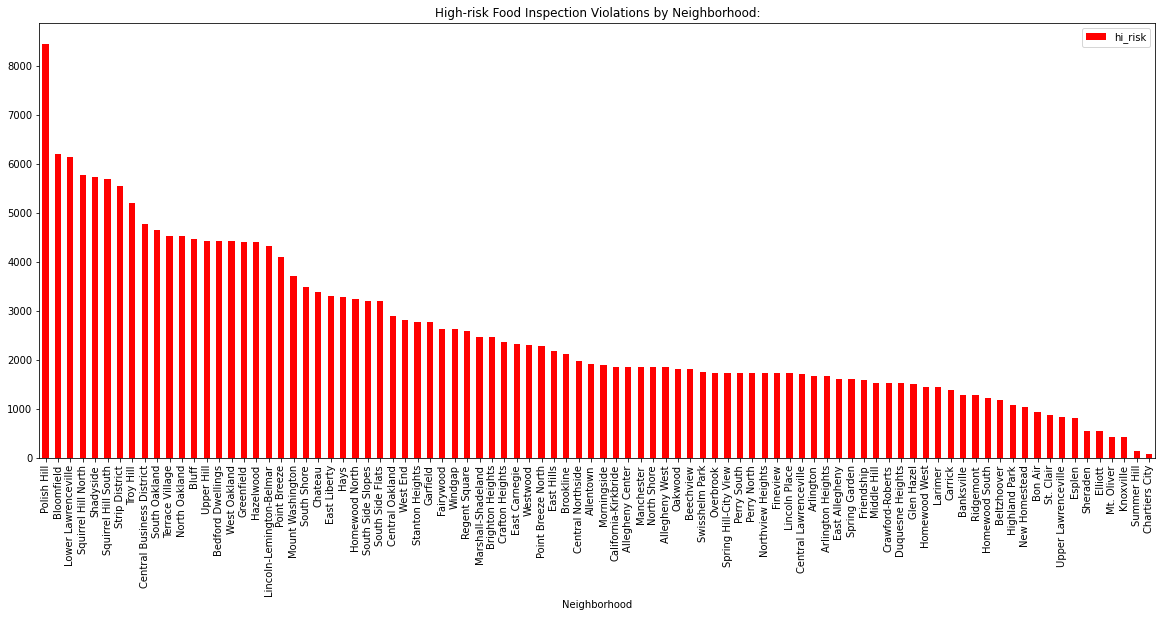

In [12]:
sort_hi = neighborhoods.sort_values("hi_risk", ascending = False)
graph_hi = sort_hi.plot(kind = "bar", x = "Neighborhood", y = "hi_risk", title = "High-risk Food Inspection Violations by Neighborhood:", figsize= (20,8), color = "red")

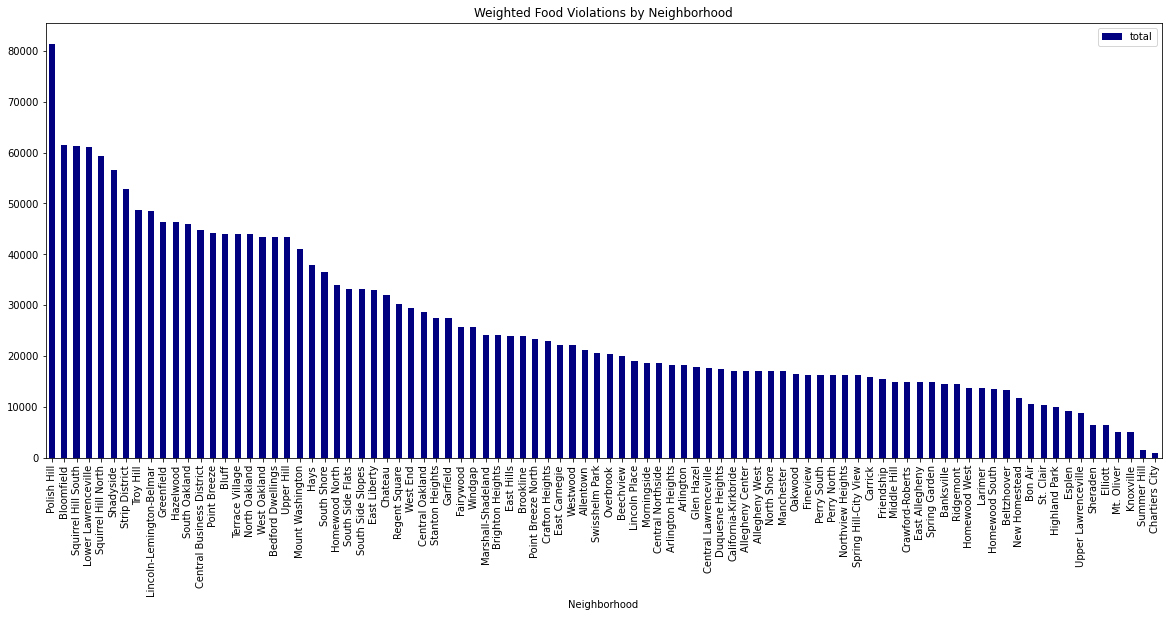

In [13]:
sort_tot = neighborhoods.sort_values("total", ascending = False)
graph_tot = sort_tot.plot(kind = "bar", x = "Neighborhood", y = "total", title = "Weighted Food Violations by Neighborhood", figsize= (20,8), color = "navy")

## Sorry&ndash;there's something about big graphs that make some of us go _hell yeah_ internally

Let's focus in on who's at the top:

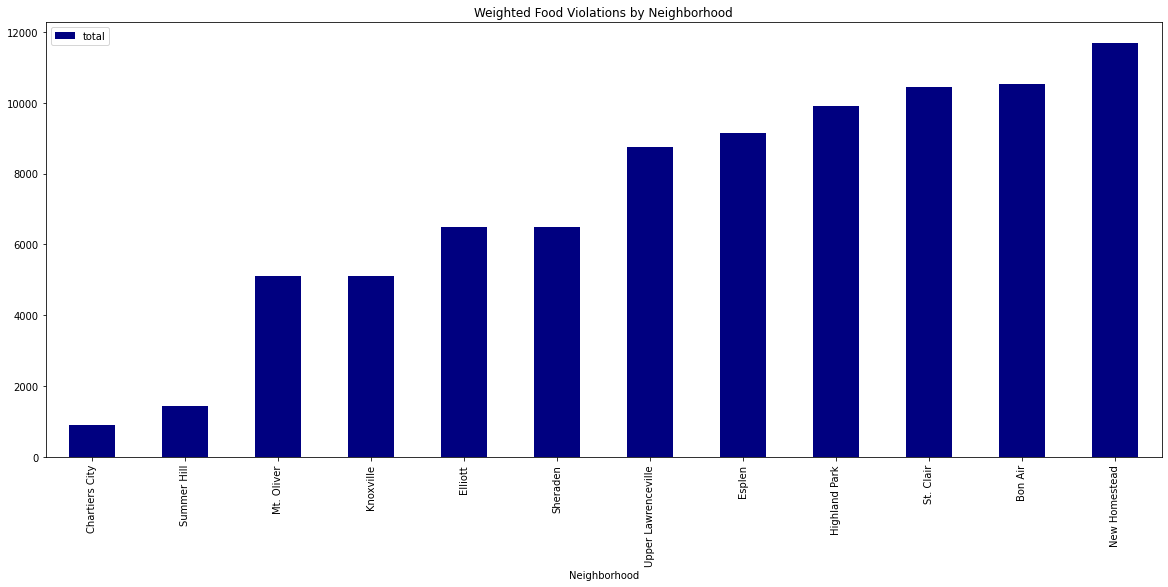

In [14]:
sort_tot = neighborhoods.sort_values("total", ascending = True)
graph_tot_top = sort_tot.iloc[:12].plot(kind = "bar", x = "Neighborhood", y = "total", title = "Weighted Food Violations by Neighborhood", figsize= (20,8), color = "navy")

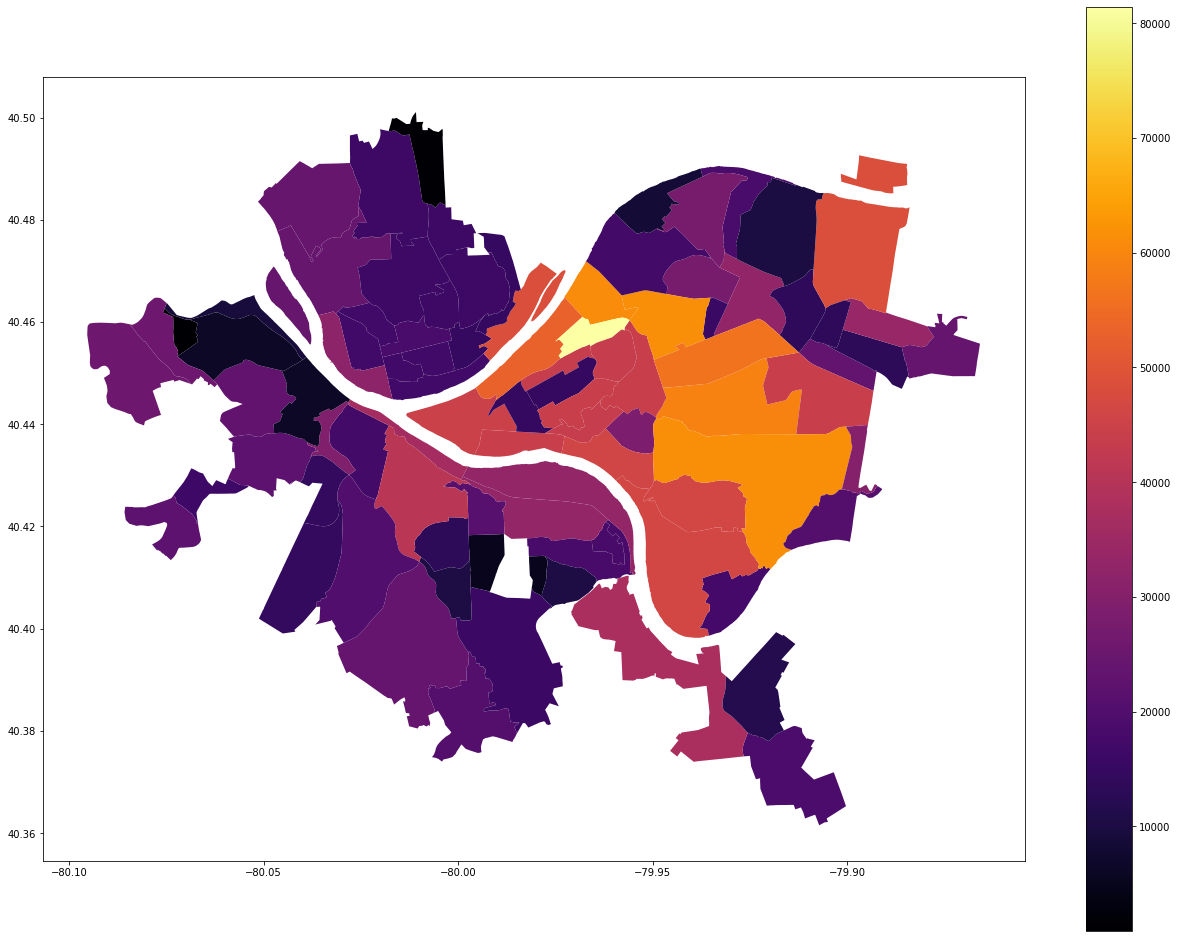

In [15]:
pgh_hood_map["# Violations"] = neighborhoods["total"]
pgh_hood_map.plot(column = "# Violations", legend = True, figsize = (22,17), cmap = 'inferno')

Finally got back to using that Geopandas map...<br>
That's all for the Food Inspection Violations Analysis!